In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, LineString
import descartes
import csv
import pandas as pd

with open('nodos.csv') as f:
    nodos = pd.read_csv(f)
    
barrios = nodos.NOMBRE[nodos.NOMBRE.duplicated()==False].values
    
DEFAULT_COLOR = {
  1:  '#8dd3c7',
  2:  '#ffffb3',
  3:  '#bebada',
  4:  '#fb8072',
  5:  '#80b1d3',
  6:  '#fdb462',
  7:  '#b3de69',
  8:  '#fccde5',
  9:  '#d9d9d9',
  10: '#bc80bd',
  11: '#ccebc5',
  12: '#ffed6f',
  13: '#b2df8a',
}

DEFAULT_BARRIOS = nodos.NOMBRE[nodos.NOMBRE.duplicated()==False].values

vecinos = {}

DEFAULT_COORDINATES  = {}

for barrio in DEFAULT_BARRIOS:
    nodos_barrio = nodos[nodos.NOMBRE==barrio]
    coordinates_barrio = zip(nodos_barrio.X.values, nodos_barrio.Y.values)
    poligon = Polygon(coordinates_barrio)
    
    DEFAULT_COORDINATES[barrio] = coordinates_barrio


def fitness(gen):
    """Returns a positive number that indicates how close the individual is to our desired solution.
    """    
    gendf = pd.DataFrame(gen)
    mad = gendf.mad()
    
    return mad.std()


# Ver Fitness.ipynb
def visualize(gen, color=DEFAULT_COLOR, barrios=DEFAULT_BARRIOS, coordinates=DEFAULT_COORDINATES, alpha=0.5):
    """Plots a solution for visual interpretation
    """
    plt.rcParams['figure.figsize'] = (20.0, 10.0)

    fig = plt.figure()
    ax = fig.add_subplot(121)
    
    # vamos de gen a barrio, dia. Como se hace?
    # sacamos el barrio, dia de la matriz de gen.
    gis = zip(barrios, coordinates.values()) 
    
    rows, columns = gen.shape

    for row in range(rows):
        for column in range(columns):
            data = gen[row, column]

            if data > 0:
                poly = coordinates[sorted(barrios)[row]]     
                ax.add_patch(descartes.PolygonPatch(Polygon(poly), fc=color[column+1], alpha=alpha))
    
    ax.axis('equal')
    
    ax2 = fig.add_subplot(122)
    gendf = pd.DataFrame(gen)
    gendf.mad().plot.bar()

    plt.show()
    
# Ver MatrizVecinos.ipynb
matriz_vecinos = pd.read_csv('adyacencia.csv', sep=';', index_col=0)

with open('lectura.csv') as f:
    lectura = pd.read_csv(f)
    
DEFAULT_CLIENTES = dict(zip(lectura.GIS, lectura.Clientes))

# Ver Genetic.ipynb
from pyevolve import G2DList
from pyevolve import GSimpleGA
from pyevolve import Selectors
from pyevolve import Crossovers
from pyevolve import Mutators
from pyevolve import GAllele
from pyevolve import Consts

from random import shuffle, randint

def cercania(cercanos, opcion_input):
    dia[dia!=0] = 1
    return sum(cercanos.dot(opcion)) - sum(opcion)

def evaluation_function(chromosome):
    # We want to give higher score to those solutions that have small mad.
    chromosome_np = np.asarray([row for row in chromosome])
    chromosome_pd = pd.DataFrame(chromosome_np)
    mad = chromosome_pd.mad()
    error = mad.std()
    
    # We want to give higher score to those solutions
    # that have barrios that are closer to each other
    # Meaning that each barrio should have at least one neighbor in the same day:
    for dia in chromosome_np.T:
        dia[dia!=0] = 1
        cercania = sum(matriz_vecinos.dot(dia)) - sum(dia)

    return 1000 / cercania

def G2DListBarrioInitializator(genome, **args):
    """ The initializator for our problem """
    
    allele = genome.getParam("allele", None)
    
    if allele is None:
        Util.raiseException("to use the G2DListBarrioInitializator, you must specify the 'allele' parameter")

    genome.clearList()

    for i in xrange(genome.getHeight()):
        options = allele[i].options
        active = randint(0, genome.getWidth())
        for j in xrange(genome.getWidth()):
            value = 0
            
            if j == active:
                value = options[i]
                
            genome.setItem(i, j, value)
            
    #shuffle(genome.genomeList)
        

def ga(dias=13, barrios=329, generations=100, freq_stats=10, clientes=DEFAULT_CLIENTES, evaluation=evaluation_function):
    # Genome instance
    genome = G2DList.G2DList(barrios, dias)
    
    # alleles are initialized from client list.
    
    alleles = GAllele.GAlleles()
    ordered_clientes = [clientes[key] for key in sorted(clientes)]
    for i, item in enumerate(ordered_clientes):
        zeros = np.zeros(len(clientes))
        zeros[i] = item
        
        a = GAllele.GAlleleList(zeros)
        alleles.add(a)
    
    genome.setParams(allele=alleles)
    
    # The evaluator function (objective function)
    genome.evaluator.set(evaluation)
    genome.crossover.set(Crossovers.G2DListCrossoverSingleHPoint)
    genome.mutator.set(Mutators.G2DListMutatorSwap)
    genome.initializator.set(G2DListBarrioInitializator)
    

    # Genetic Algorithm Instance
    ga = GSimpleGA.GSimpleGA(genome)
    ga.setGenerations(generations)
    ga.setMutationRate(0.1);
    ga.setMinimax(Consts.minimaxType["minimize"])
    ga.terminationCriteria.set(GSimpleGA.ConvergenceCriteria)

    # Do the evolution, with stats dump
    # frequency of 10 generations
    ga.evolve(freq_stats=freq_stats)
    return ga.bestIndividual()

def ga_to_array(solution):
    return np.asarray([row for row in solution], dtype=np.uint16)

In [2]:
# Cargar matriz de vecinos.

In [3]:
dias = dict(zip(lectura.GIS, lectura.Dia))

initial_solution = np.zeros((len(lectura.GIS), len(lectura.Dia.unique()+1)))


for index, barrio in enumerate(sorted(lectura.GIS)):
    initial_solution[index, dias[barrio]-1] = DEFAULT_CLIENTES[barrio]

## Antes de empezar a generar soluciones mejores que la inicial, grafiquemos el MAD y la ubicación espacial de esa solución

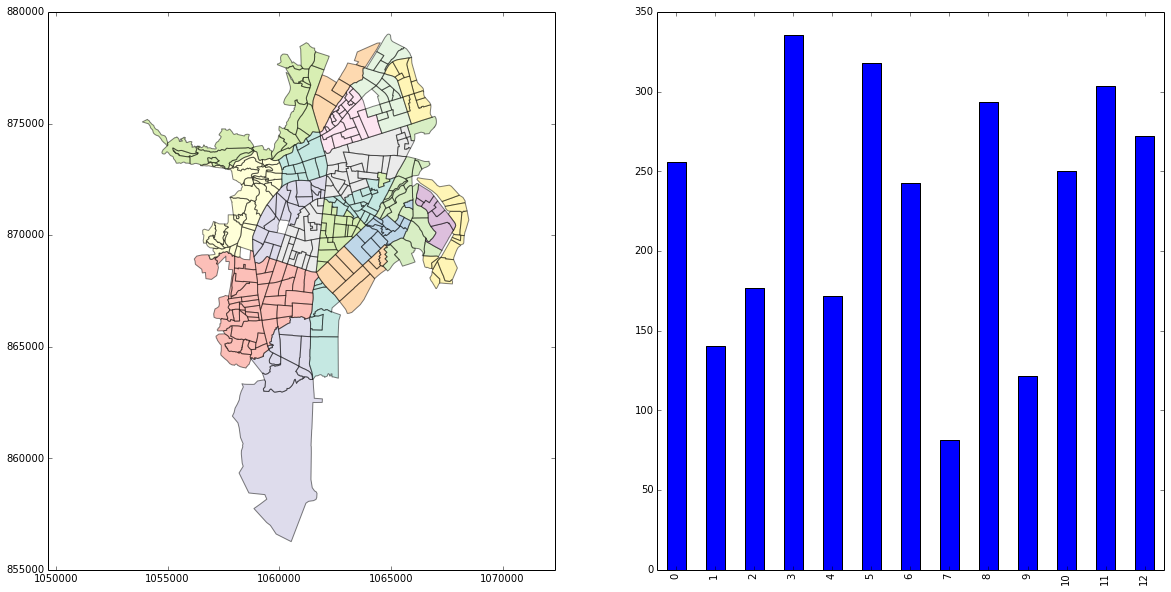

In [4]:
visualize(initial_solution)

In [5]:
def g(generations):
    our_solution_ga = ga(generations=generations, freq_stats=generations/10)
    our_solution = ga_to_array(our_solution_ga)
    visualize(our_solution)
    print pd.DataFrame(our_solution)

ERROR: No traceback has been produced, nothing to debug.


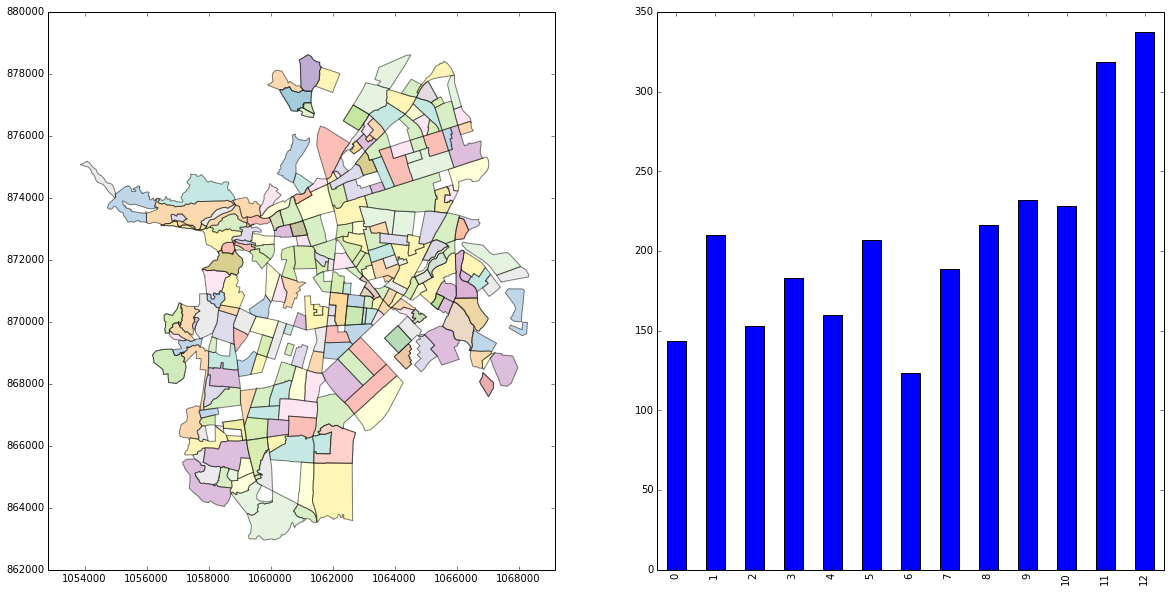

       0     1     2     3     4     5     6     7     8   9     10     11  \
0       0     0     0     0     0   860     0     0     0   0     0      0   
1       0     0     0     0     0     0     0     0     0   0     0      0   
2       0     0     0     0     0     0     0     0     0   0     0      0   
3       0     0     3     0     0     0     0     0     0   0     0      0   
4       0     0     0     0     0     0  1344     0     0   0     0      0   
5    2626     0     0     0     0     0     0     0     0   0     0      0   
6       0     0     0     0     0     0     0     0     0   0     0      0   
7     388     0     0     0     0     0     0  3233     0   0     0      0   
8       0     0     0     0     0     0     0     0     0   0  6492   1679   
9       0  1195     0     0     0     0     0     0     0   0     0      0   
10      0     0     0     0     0   734     0     0  5657   0     0      0   
11      0   166     0     0     0     0     0     0     0   0   

In [6]:
%debug
%time g(1)

Gen. 0 (0.00%): Max/Min/Avg Fitness(Raw) [10.68(20.83)/8.31(4.93)/8.90(8.90)]
Gen. 1 (10.00%): Max/Min/Avg Fitness(Raw) [6.55(6.85)/4.57(4.33)/5.46(5.46)]
Gen. 2 (20.00%): Max/Min/Avg Fitness(Raw) [5.71(6.06)/4.17(3.95)/4.76(4.76)]
Gen. 3 (30.00%): Max/Min/Avg Fitness(Raw) [5.24(5.35)/3.74(3.66)/4.36(4.36)]
Gen. 4 (40.00%): Max/Min/Avg Fitness(Raw) [4.91(5.18)/3.52(3.33)/4.09(4.09)]
Gen. 5 (50.00%): Max/Min/Avg Fitness(Raw) [4.49(4.57)/3.29(3.25)/3.75(3.75)]
Gen. 6 (60.00%): Max/Min/Avg Fitness(Raw) [4.37(4.37)/3.06(3.06)/3.64(3.64)]
Gen. 7 (70.00%): Max/Min/Avg Fitness(Raw) [4.10(4.24)/2.98(2.90)/3.42(3.42)]
Gen. 8 (80.00%): Max/Min/Avg Fitness(Raw) [3.90(3.85)/2.65(2.70)/3.25(3.25)]
Gen. 9 (90.00%): Max/Min/Avg Fitness(Raw) [3.70(3.39)/2.25(2.67)/3.08(3.08)]
Gen. 10 (100.00%): Max/Min/Avg Fitness(Raw) [3.65(3.61)/2.64(2.67)/3.04(3.04)]
Total time elapsed: 10.291 seconds.


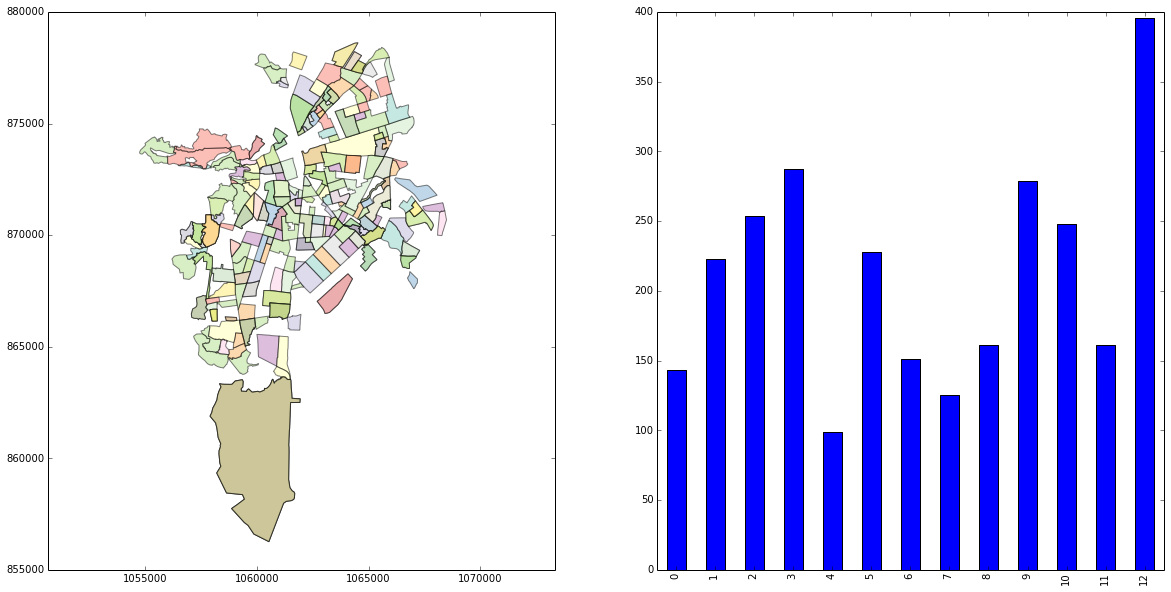

       0     1     2     3     4     5     6    7     8     9     10   11  \
0       0     0     0     0     0     0     0    0     0   536     0    0   
1       0     0     0     0     0     0     0    0     0     0     0    0   
2       0     0     0     0     0     0     0    0     0     0     0  495   
3       0     0     0     0     0     0     0    0     0    53     0    0   
4       0     0     0     0     0     0     0    0     0     0     0    0   
5       0     0     0   481     0     0     0    0     0     0     0    0   
6       0     0     0     0     0     0     0    0     0     0     0    0   
7       0     0     0     0     0     0     0    0  4302     0     0    0   
8       0     0     0     0     0     0     0    0     0     0     0    0   
9    4962     0     0     0     0     0     0    0     0     0     0    0   
10   5657     0     0     0     0     0     0    0     0     0     0    0   
11      0     0     0     0     0     0     0    0     0     0  1994    0   

In [7]:
%time g(10)

Gen. 0 (0.00%): Max/Min/Avg Fitness(Raw) [10.63(14.93)/7.74(5.03)/8.86(8.86)]
Gen. 100 (10.00%): Max/Min/Avg Fitness(Raw) [2.81(2.65)/1.84(2.01)/2.34(2.34)]
Gen. 200 (20.00%): Max/Min/Avg Fitness(Raw) [2.75(2.57)/1.75(1.96)/2.29(2.29)]
Gen. 300 (30.00%): Max/Min/Avg Fitness(Raw) [2.62(2.47)/1.72(1.88)/2.18(2.18)]

	A break was detected, you have interrupted the evolution !

Gen. 388 (38.80%): Max/Min/Avg Fitness(Raw) [2.59(2.40)/1.65(1.86)/2.15(2.15)]
Total time elapsed: 422.483 seconds.


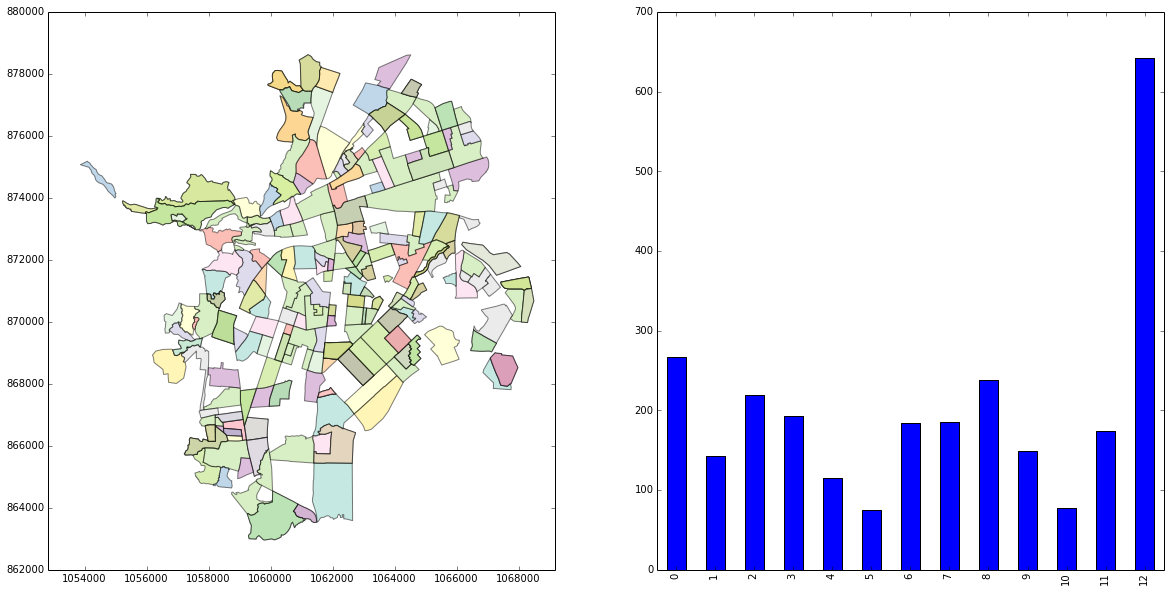

       0    1     2     3   4     5     6     7     8     9     10    11    12
0       0    0     0     0   0     0     0     0     0     0     0     0     0
1     408    0     0     0   0     0     0     0     0     0     0     0   545
2       0    0     0     0   0   368     0     0     0     0     0     0     0
3       0    0     0     0   0     0     0     0     0     0     0     0   778
4       0    0     0     0   0     0     0     0     0     0     0     0     0
5       0    0     0     0   0     0     0     0     0     0     0  1331   826
6    1379    0     0     0   0     0     0     0     0     0     0     0  3371
7       0    0     0     0   0     0     0     0     0     0     0     0     0
8       0    0     0   757   0     0     0  3048     0     0     0     0     0
9       0    0     0  1476   0     0     0     0     0     0     0     0   778
10      0    0     0     0   0     0     0     0     0     0     0     0     0
11      0    0     0     0   0     0     0     0    

In [8]:
%time g(1000)

In [ ]:
visualize(our_solution)

In [ ]:
import numpy as np
cercanos = np.array([[0, 1, 0, 1],
                     [1, 0, 0, 1],
                     [0, 0, 0, 0],
                     [1, 1, 0, 0]
                    ])

In [ ]:
opcion1 = np.array([1, 1, 0, 1])
opcion2 = np.array([1, 0, 1, 0])
opcion3 = np.array([0, 1, 0, 1])
opcion4 = np.array([1, 1, 1, 1])

In [ ]:
def evaluar(cercanos, opcion_input):
    opcion_in = pd.DataFrame(opcion_input)
    opcion_unos = opcion_in.where(opcion_in!=0) / opcion_in
    opcion = np.nan_to_num(opcion_unos)
    return sum(cercanos.dot(opcion)) - sum(opcion)

In [ ]:
evaluar(cercanos, opcion1), evaluar(cercanos, opcion2), evaluar(cercanos, opcion3), evaluar(cercanos, opcion4)

In [ ]:
dia